### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
print(device)

cuda


### Data Loading & Cleaning

In [3]:
# Load dataset
data_path = 'spain_energy_meteo_data.csv'
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Use all features for input
all_features = df.columns.tolist()

# Handle missing values
data = df.fillna(method='ffill')

C:\Users\student11\AppData\Local\Temp\ipykernel_38924\1784617096.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.fillna(method='ffill')


In [4]:
display(data)

,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore
Date,,,,,,,,,,,
1980-01-01,63.712332,101892.963958,282.782622,0.001628,3.967427,6.825222,555442.4,75105.17,27625.16,7414.011781,241681.204853
1980-01-02,76.356610,102279.375083,280.568923,0.000416,3.075484,5.265852,668316.5,74774.20,27676.85,9667.063190,141812.976918
1980-01-03,103.318422,102547.714417,277.943976,0.000005,1.731207,2.884409,692024.2,74066.41,28220.82,14965.925374,28256.394755
1980-01-04,99.630959,102265.270542,278.233487,0.000728,1.816051,3.011657,693162.4,74689.07,28344.47,14105.305812,36945.997648
1980-01-05,84.680324,102225.539208,278.408883,0.000794,2.186170,3.756692,624292.7,74882.60,28480.01,11298.820055,72234.129754
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,143.957778,102796.901583,282.747021,0.001501,2.496270,4.200499,700110.3,66117.47,30107.25,15865.123549,95783.220015
2025-02-25,110.305063,102545.382667,282.309362,0.001773,3.193231,5.403183,725569.3,66875.40,30080.05,11142.786919,138396.892727
2025-02-26,187.718245,102601.983000,280.700744,0.000090,2.010059,3.276983,724012.9,64955.26,29987.86,21820.251802,42084.705472


In [5]:
data_y_energy = data[['Electricity Demand', 'Hydropower reservoir', 'Hydropower run-of-river', 'Solar PV Power', 'Wind Power Onshore']]

targets_energy = data_y_energy.columns.tolist()

print(targets_energy)
display(data_y_energy)

['Electricity Demand', 'Hydropower reservoir', 'Hydropower run-of-river', 'Solar PV Power', 'Wind Power Onshore']


,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore
Date,,,,,
1980-01-01,555442.4,75105.17,27625.16,7414.011781,241681.204853
1980-01-02,668316.5,74774.20,27676.85,9667.063190,141812.976918
1980-01-03,692024.2,74066.41,28220.82,14965.925374,28256.394755
1980-01-04,693162.4,74689.07,28344.47,14105.305812,36945.997648
1980-01-05,624292.7,74882.60,28480.01,11298.820055,72234.129754
...,...,...,...,...,...
2025-02-24,700110.3,66117.47,30107.25,15865.123549,95783.220015
2025-02-25,725569.3,66875.40,30080.05,11142.786919,138396.892727
2025-02-26,724012.9,64955.26,29987.86,21820.251802,42084.705472


In [6]:
data_y_meteo = data[['Global Horizontal Irradiance', 'Mean Sea Level Pressure', 'Air Temperature', 'Total Precipitation', 'Wind Speed_x', 'Wind Speed_y']]

targets_meteo = data_y_meteo.columns.tolist()

print(targets_meteo)
display(data_y_meteo)

['Global Horizontal Irradiance', 'Mean Sea Level Pressure', 'Air Temperature', 'Total Precipitation', 'Wind Speed_x', 'Wind Speed_y']


,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y
Date,,,,,,
1980-01-01,63.712332,101892.963958,282.782622,0.001628,3.967427,6.825222
1980-01-02,76.356610,102279.375083,280.568923,0.000416,3.075484,5.265852
1980-01-03,103.318422,102547.714417,277.943976,0.000005,1.731207,2.884409
1980-01-04,99.630959,102265.270542,278.233487,0.000728,1.816051,3.011657
1980-01-05,84.680324,102225.539208,278.408883,0.000794,2.186170,3.756692
...,...,...,...,...,...,...
2025-02-24,143.957778,102796.901583,282.747021,0.001501,2.496270,4.200499
2025-02-25,110.305063,102545.382667,282.309362,0.001773,3.193231,5.403183
2025-02-26,187.718245,102601.983000,280.700744,0.000090,2.010059,3.276983


### Data Normalization

In [11]:
# Normalize data
# scalerX = MinMaxScaler()
scalerX = StandardScaler()
# scalerX = RobustScaler()
dataX_scaled = scalerX.fit_transform(data)

# scalerY = MinMaxScaler()
scalerY_energy = StandardScaler()
# scalerY = RobustScaler()
data_y_energy_scaled = scalerY_energy.fit_transform(data_y_energy)

scalerYmeteo = StandardScaler()
# scalerYmeteo = MinMaxScaler()
# scalerYmeteo = RobustScaler()
data_y_meteo_scaled = scalerYmeteo.fit_transform(data_y_meteo)

In [12]:
print(dataX_scaled.shape, data_y_energy_scaled.shape, data_y_meteo_scaled.shape)

(16496, 11) (16496, 5) (16496, 6)


### Sequence Generation for LSTM

In [13]:
def create_sequences(dataX, data_y, seq_length, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - prediction_horizon + 1):
        X.append(dataX[i:i+seq_length])
        y.append(data_y[i+seq_length+prediction_horizon-1])
    return np.array(X), np.array(y)

seq_length = 30*10  # Use past 30 days to predict
prediction_horizon = 30  # Predict 30 days ahead

X, y1 = create_sequences(dataX_scaled, data_y_energy_scaled, seq_length, prediction_horizon)
X, y2 = create_sequences(dataX_scaled, data_y_meteo_scaled, seq_length, prediction_horizon)

In [14]:
print(X.shape, y1.shape) # (samples, sequence length, features), (samples, features)
print(X.shape, y2.shape) # (samples, sequence length, features), (samples, features)

(16167, 300, 11) (16167, 5)
(16167, 300, 11) (16167, 6)


### GRU Model Definition

In [17]:
class GRUModelEnergy(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModelEnergy, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        # Initialize FC weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x, h0=None):
        # If hidden state is not provided, initialize it as zeros
        if h0 is None:
            h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        
        gru_out, hn = self.gru(x, h0)
        x = self.fc1(gru_out[:, -1, :])  # Use the last output of the GRU
        x = self.relu(x)
        return self.fc2(x), hn

input_size = len(all_features)
hidden_size = 200  # Increased hidden size for better feature learning
num_layers = 4  # Increased number of layers for deeper representation
output_size = len(targets_energy)
dropout = 0.1  # Added dropout for regularization

gru_model_energy = GRUModelEnergy(input_size, hidden_size, num_layers, output_size, dropout).to(device)

print(f"Nb of hyperparamters in {gru_model_energy.__class__.__name__}: {sum(p.numel() for p in gru_model_energy.parameters() if p.requires_grad):,}")

Nb of hyperparamters in GRUModelEnergy: 872,005


In [18]:
class GRUModelMeteo(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModelMeteo, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        # Initialize FC weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x, h0=None):
        # If hidden state is not provided, initialize it as zeros
        if h0 is None:
            h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        
        gru_out, hn = self.gru(x, h0)
        x = self.fc1(gru_out[:, -1, :])  # Use the last output of the GRU
        x = self.relu(x)
        return self.fc2(x), hn

input_size = len(all_features)
hidden_size = 200  # Increased hidden size for better feature learning
num_layers = 4  # Increased number of layers for deeper representation
output_size = len(targets_meteo)
dropout = 0.1  # Added dropout for regularization

gru_model_meteo = GRUModelMeteo(input_size, hidden_size, num_layers, output_size, dropout).to(device)

print(f"Nb of hyperparamters in {gru_model_meteo.__class__.__name__}: {sum(p.numel() for p in gru_model_meteo.parameters() if p.requires_grad):,}")

Nb of hyperparamters in GRUModelMeteo: 872,106


In [20]:
path_model_energy = r'GRUModelEnergy.pth'
gru_model_energy.load_state_dict(torch.load(path_model_energy))

<All keys matched successfully>

In [21]:
path_model_meteo = r'GRUModelMeteo.pth'
gru_model_meteo.load_state_dict(torch.load(path_model_meteo))

<All keys matched successfully>

### Prediction for Next Month

In [22]:
def predict_next_month(model, last_data, steps=30):
    model.eval()
    predictions = []
    input_seq = torch.tensor(last_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    for _ in range(steps):
        with torch.no_grad():
            pred = model(input_seq).squeeze(0)  # Remove batch dimension
        predictions.append(pred.numpy())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.unsqueeze(0).unsqueeze(1)), dim=1)  # Shift left and append new prediction
    return np.array(predictions)

# Take last sequence and predict next month
last_sequence = X[-1]
print(last_sequence.shape)
last_sequence_y_energy = y1[-1]
print(last_sequence_y_energy.shape)
last_sequence_y_meteo = y2[-1]
print(last_sequence_y_meteo.shape)

(300, 11)
(5,)
(6,)


In [ ]:
gru_model_energy.eval()
gru_model_meteo.eval()

predictions = []

input = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)
print(input.shape)
print(input.device)

for _ in range(prediction_horizon):
    with torch.no_grad():

        input = input.to(device)
        
        h0 = None  # Initialize hidden and cell states
        
        # outputs1 : (1, 5)
        outputs1, h0 = gru_model_energy(input, h0)
        
        # outputs2 : (1, 6)
        outputs2, h0 = gru_model_meteo(input, h0)
        
        # Detach hidden and cell states to prevent backpropagation through the entire sequence
        h0 = h0.detach()
        
    predictions.append(outputs1.cpu().numpy())
    
    
    # Combine outputs1 and outputs2 to form the 11 features
    combined_outputs = torch.cat((outputs2, outputs1), dim=1)
    # print(combined_outputs.shape) # (1, 11)

    # Add the combined outputs to the input sequence
    # print(input[:, 1:, :].shape) # (1, 299, 11)
    input = torch.cat((input[:, 1:, :], combined_outputs.unsqueeze(0)), dim=1)

print(len(predictions)) # 30
print(predictions[0].shape) # (1, 5)

torch.Size([1, 300, 11])
cpu
30
(1, 5)


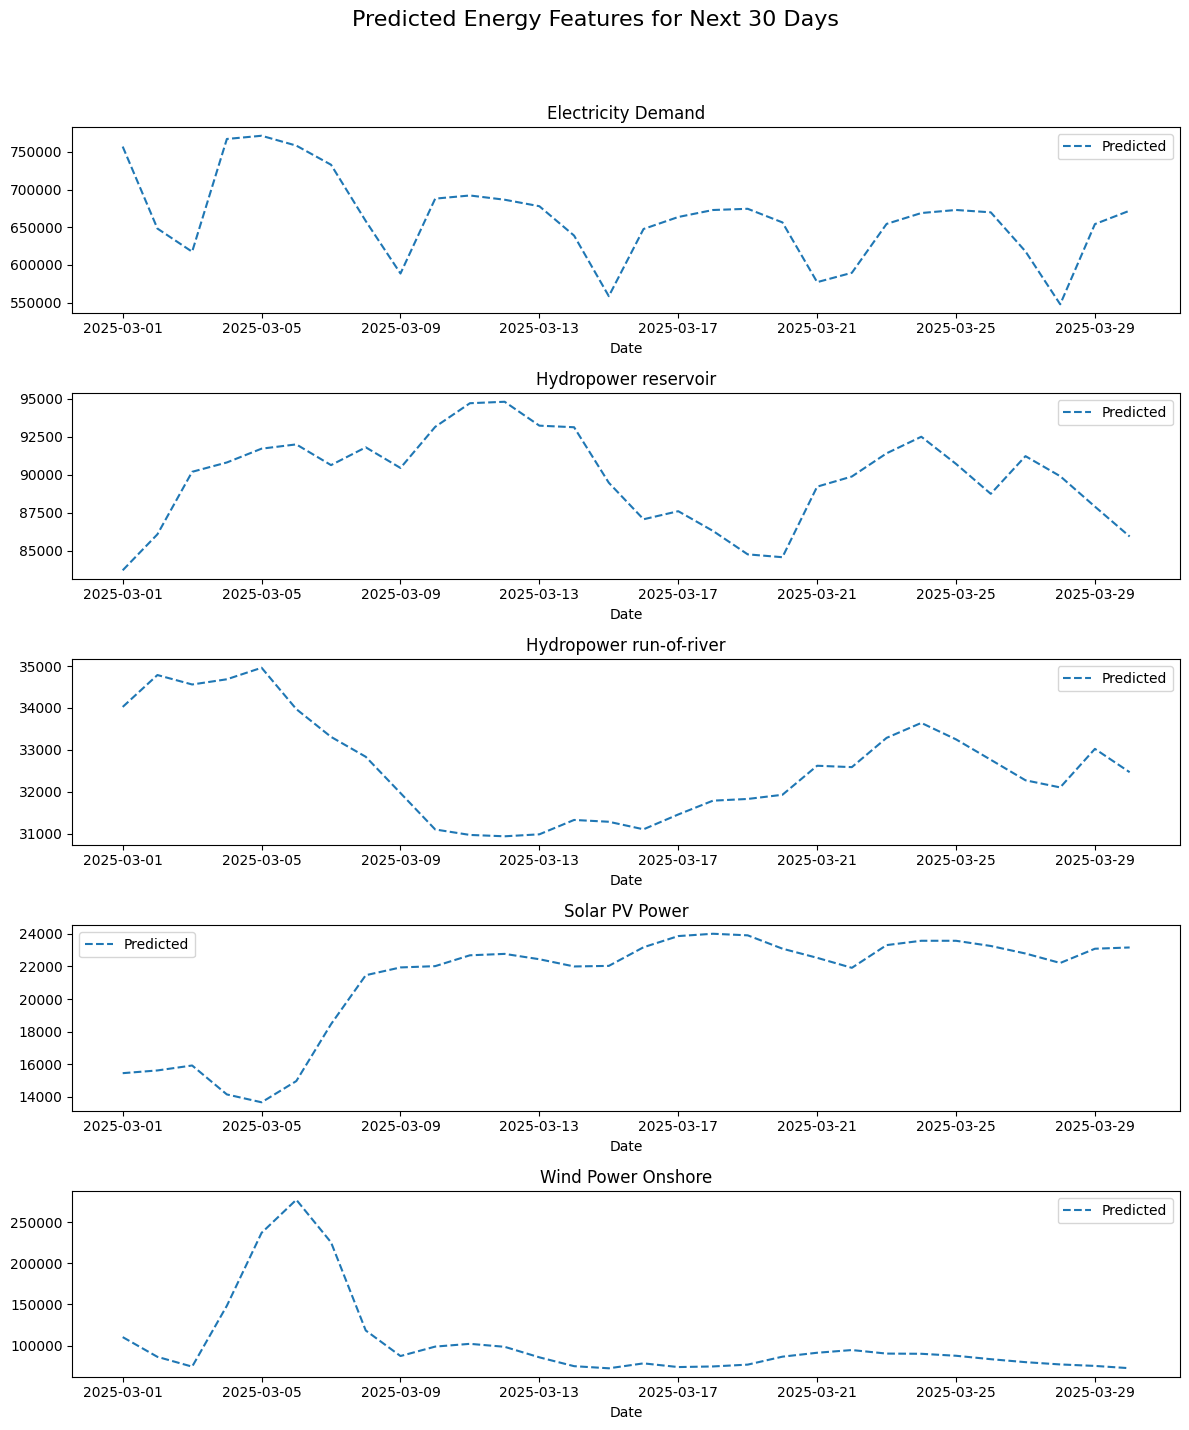

In [32]:
# Convert predictions list to numpy array
predictions_array = np.array(predictions).squeeze(axis=1)  # Remove unnecessary dimensions

# Inverse transform the predictions
predictions_inv = scalerY_energy.inverse_transform(predictions_array)

# Generate future dates for the x-axis
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=prediction_horizon, freq='D')

# Plot each feature in a subplot
num_features = len(targets_energy)
plt.figure(figsize=(12, num_features * 3))
plt.suptitle("Predicted Energy Features for Next 30 Days", fontsize=16)

for i, feature in enumerate(targets_energy):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(future_dates, predictions_inv[:, i], label="Predicted", linestyle='dashed')
    plt.title(feature)
    plt.xlabel("Date")
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

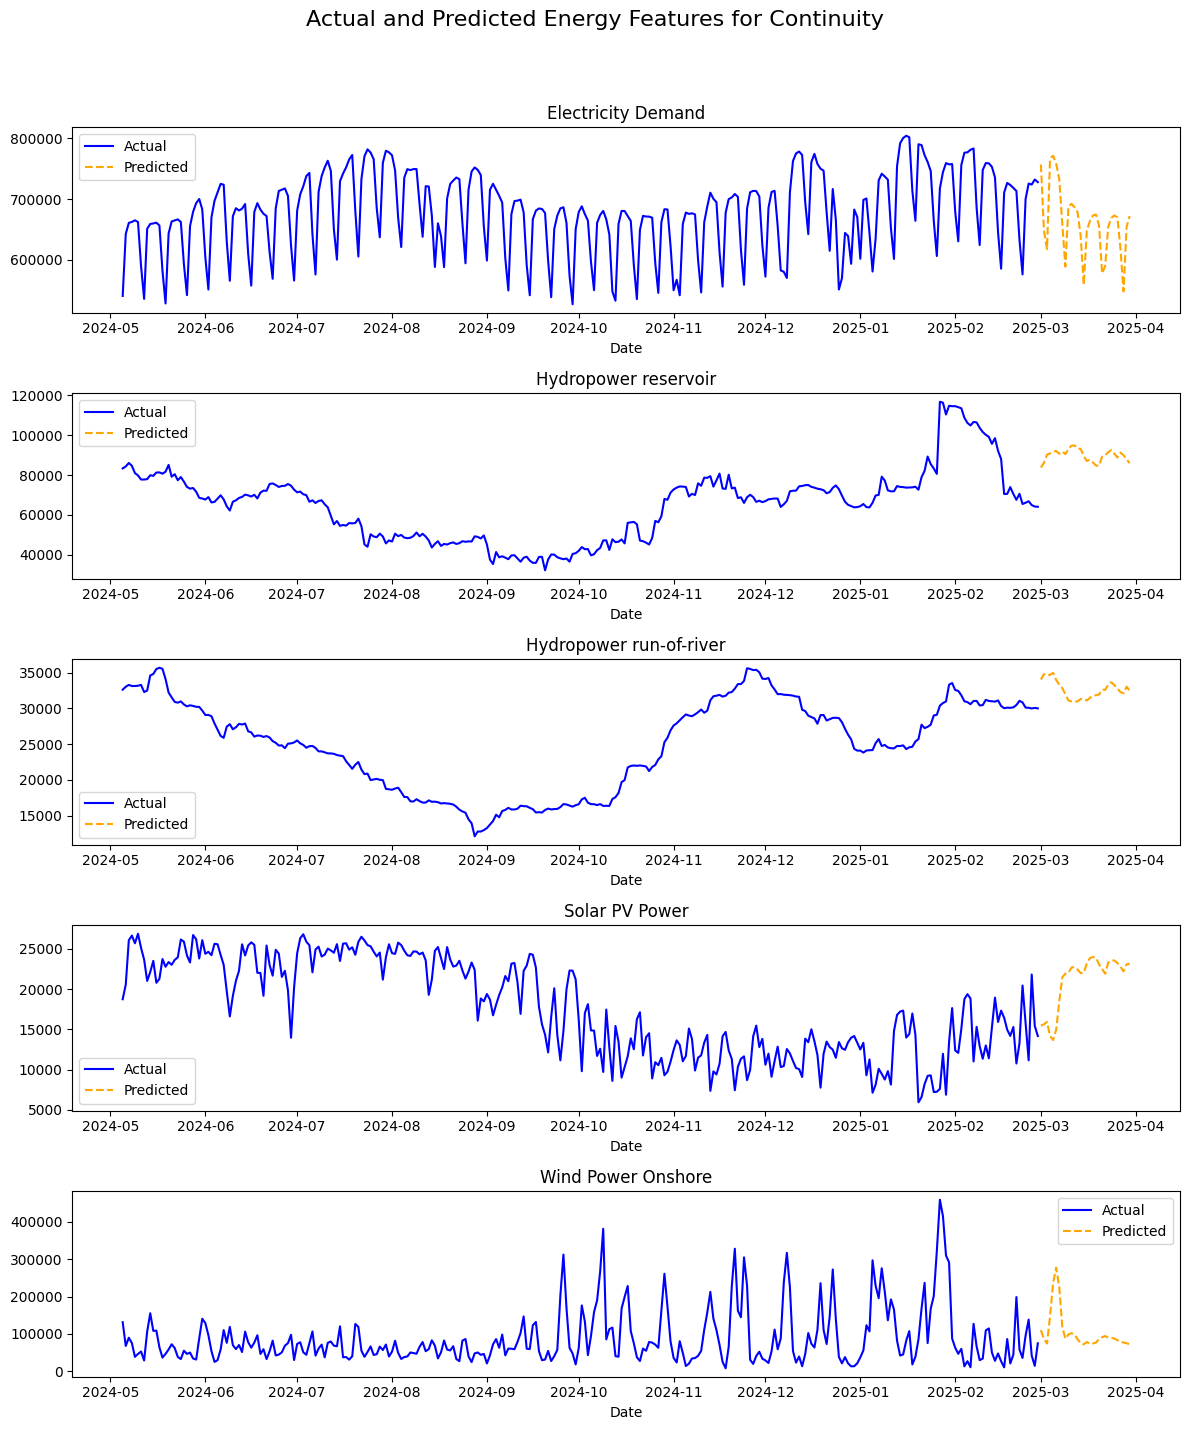

In [35]:
# Extract the actual data for the last sequence of days
actual_data = data_y_energy.iloc[-seq_length:]

# Generate dates for the actual data
actual_dates = actual_data.index

# Plot each feature in a subplot
num_features = len(targets_energy)
plt.figure(figsize=(12, num_features * 3))
plt.suptitle("Actual and Predicted Energy Features for Continuity", fontsize=16)

for i, feature in enumerate(targets_energy):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(actual_dates, actual_data[feature], label="Actual", color='blue')
    plt.plot(future_dates, predictions_inv[:, i], label="Predicted", linestyle='dashed', color='orange')
    plt.title(feature)
    plt.xlabel("Date")
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [33]:
# Create a DataFrame for predictions
predictions_df = pd.DataFrame(predictions_inv, columns=targets_energy)
predictions_df.insert(0, 'Date', future_dates)

# Display the DataFrame
display(predictions_df)

,Date,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore
0,2025-03-01,757053.5000,83731.585938,34025.203125,15454.144531,110331.539062
1,2025-03-02,648307.5625,86094.085938,34786.093750,15621.398438,86364.906250
2,2025-03-03,617554.5625,90196.179688,34560.570312,15925.052734,74467.468750
3,2025-03-04,767141.1250,90809.648438,34684.898438,14150.304688,148418.203125
4,2025-03-05,771404.5000,91715.921875,34959.613281,13668.654297,236934.531250
5,2025-03-06,758334.5000,91996.117188,33972.968750,14970.279297,277096.312500
6,2025-03-07,732971.9375,90635.726562,33310.332031,18457.750000,225422.671875
7,2025-03-08,658271.2500,91803.343750,32835.425781,21460.349609,118363.000000
8,2025-03-09,588640.6250,90448.257812,31969.908203,21936.992188,87346.812500
9,2025-03-10,688008.9375,93147.929688,31101.132812,22016.138672,98807.835938


In [34]:
predictions_df.to_csv("predictions.csv", index=False)